In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import utils as u
import importlib
importlib.reload(u)
import sbpy.data as sso_py
import pandas as pd
import numpy as np

from astropy.time import Time
import astropy.units as ut
import multiprocessing as mp
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

# Ephemeries deviation

In [3]:
reconstructed_orbit, reconstructed_trajectory, input_data = u.get_tw_exp("15_2_2", "all")

mpc_orb = pd.read_parquet("../data/MPC_Database/mpcorb_extended.parquet",
    columns=["Number", "Name", "Principal_desig", "Other_desigs", "a", "e", "i", "Node", "Peri", "M", "Epoch", "Orbit_type"])

In [4]:
# take only the pure with error
prep_ephem = u.ephem_preparation(reconstructed_orbit, reconstructed_trajectory, mpc_orb)

In [5]:
ff_orbit_column = [
    "ssoCandId",
    "ref_epoch",
    "a_y",
    "e_y",
    "i_y",
    "long. node",
    "arg. peric",
    "mean anomaly",
]

ff_column__rename = {
    "ssoCandId": "targetname",
    "a_y": "a",
    "e_y": "e",
    "i_y": "i",
    "long. node": "node",
    "arg. peric": "argper",
    "mean anomaly": "M",
    "ref_epoch": "epoch",
}

mpc_orbit_column = [
    "ssoCandId",
    "Epoch",
    "a_x",
    "e_x",
    "i_x",
    "Node",
    "Peri",
    "M",
]

mpc_column__rename = {
    "ssoCandId": "targetname",
    "a_x": "a",
    "e_x": "e",
    "i_x": "i",
    "Node": "node",
    "Peri": "argper",
    "Epoch": "epoch",
}

In [6]:
def compute_mpc_ff_ephem(prep_ephem, candid):
    current_orb = prep_ephem[prep_ephem["ssoCandId"] == candid]

    ff_tab_orb = u.df_to_orb(current_orb, ff_orbit_column, ff_column__rename)
    mpc_tab_orb = u.df_to_orb(current_orb, mpc_orbit_column, mpc_column__rename)
    
    ff_ephem = [
        sso_py.Ephem.from_oo(
            ff_tab_orb, epochs=Time(current_orb[f"jd+{delta_t}"], format="jd"), location="I41", scope="basic"
        ).table.to_pandas()[["targetname", "RA", "DEC"]] for delta_t in [7, 30, 120, 360]
    ]
    
    mpc_ephem = [
        sso_py.Ephem.from_oo(
            mpc_tab_orb, epochs=Time(current_orb[f"jd+{delta_t}"], format="jd"), location="I41", scope="basic"
        ).table.to_pandas()[["targetname", "RA", "DEC"]] for delta_t in [7, 30, 120, 360]
    ]

    return ff_ephem, mpc_ephem

In [7]:
def compute_batch_ephem(candid_list):

    ff_ephem_res = []
    mpc_ephem_res = []

    for candid in candid_list:
        
        ff_ephem, mpc_ephem = compute_mpc_ff_ephem(prep_ephem, candid)

        ff_ephem_res.append(ff_ephem)
        mpc_ephem_res.append(mpc_ephem)
    
    return ff_ephem_res, mpc_ephem_res


        #q.put(ephem)
        # i = 0
        # for delta_t in [30, 120, 360]:
        #     prep_ephem.loc[current_orb.index, f"ff_ra_{delta_t}"] = ephem[i]["RA"].values
        #     prep_ephem.loc[current_orb.index, f"ff_dec_{delta_t}"] = ephem[i]["DEC"].values
        #     i+=1

In [8]:
nb_proc = 50
chunk_cand = [(el,) for el in np.array_split(prep_ephem["ssoCandId"], nb_proc)]

In [9]:

with mp.Pool(nb_proc) as pool:
    ephem_res = pool.starmap(compute_batch_ephem, chunk_cand)

In [89]:
def ephem_sep(ephem_res, index_delta_t):
    ff_ephem = pd.concat([el[index_delta_t] for res_proc in ephem_res for el in res_proc[0]])
    mpc_ephem = pd.concat([el[index_delta_t] for res_proc in ephem_res for el in res_proc[1]])
    
    ff_coord = SkyCoord(ff_ephem["RA"], ff_ephem["DEC"], unit=ut.degree)
    mpc_coord = SkyCoord(mpc_ephem["RA"], mpc_ephem["DEC"], unit=ut.degree)

    sep = ff_coord.separation(mpc_coord).arcminute

    return pd.DataFrame({
        "ssoCandId": ff_ephem["targetname"],
        "sep": sep
    })

In [90]:
sep_7 = ephem_sep(ephem_res, 0)
sep_30 = ephem_sep(ephem_res, 1)
sep_120 = ephem_sep(ephem_res, 2)
sep_360 = ephem_sep(ephem_res, 3)

In [91]:
tmp_prep = prep_ephem.merge(sep_120, on="ssoCandId")

In [92]:
tmp = np.unique(tmp_prep["Orbit_type"])
tr_orb = {j:i for i, j in enumerate(tmp)}

tmp_prep["cat_orb"] = tmp_prep["Orbit_type"].map(lambda x: tr_orb[x])

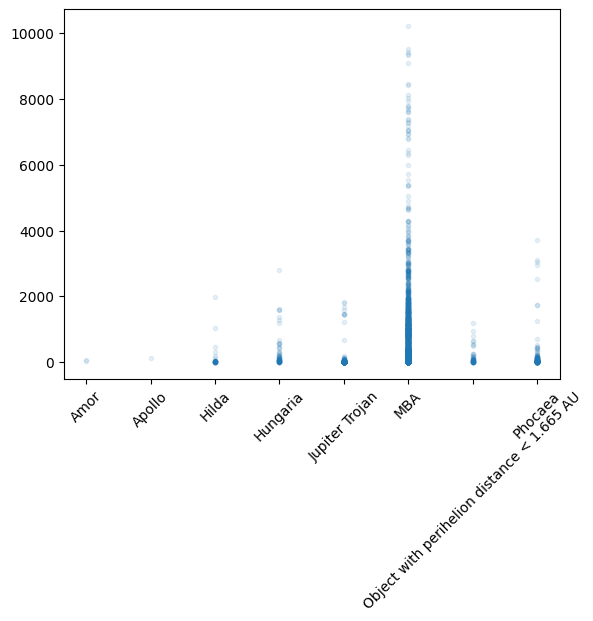

In [93]:
plt.scatter(tmp_prep["cat_orb"], tmp_prep["sep"], marker='.', alpha=0.1)
ax = plt.gca()
plt.xticks(ticks=list(tr_orb.values()), labels=list(tr_orb.keys()), rotation=45)
plt.show()

In [98]:
print("median 7 day: {:.4f} arcminute".format(np.median(sep_7["sep"])))

median 7 day: 0.8691 arcminute


In [99]:
fig = plt.figure(figsize=(15, 8))

plt.hist(sep_7[sep_7 < np.percentile(sep_7, 99)].arcminute, bins=200, label="7 days")

plt.yscale("log")
plt.xlabel("separation between fink_fat ephemeries and mpc orbit ephemeries (arcminute)")
plt.legend()
plt.show()

TypeError: '<' not supported between instances of 'float' and 'str'

<Figure size 1500x800 with 0 Axes>

In [100]:
print("median 30 day: {:.4f} arcminute".format(np.median(sep_30["sep"])))

median 30 day: 7.3934 arcminute


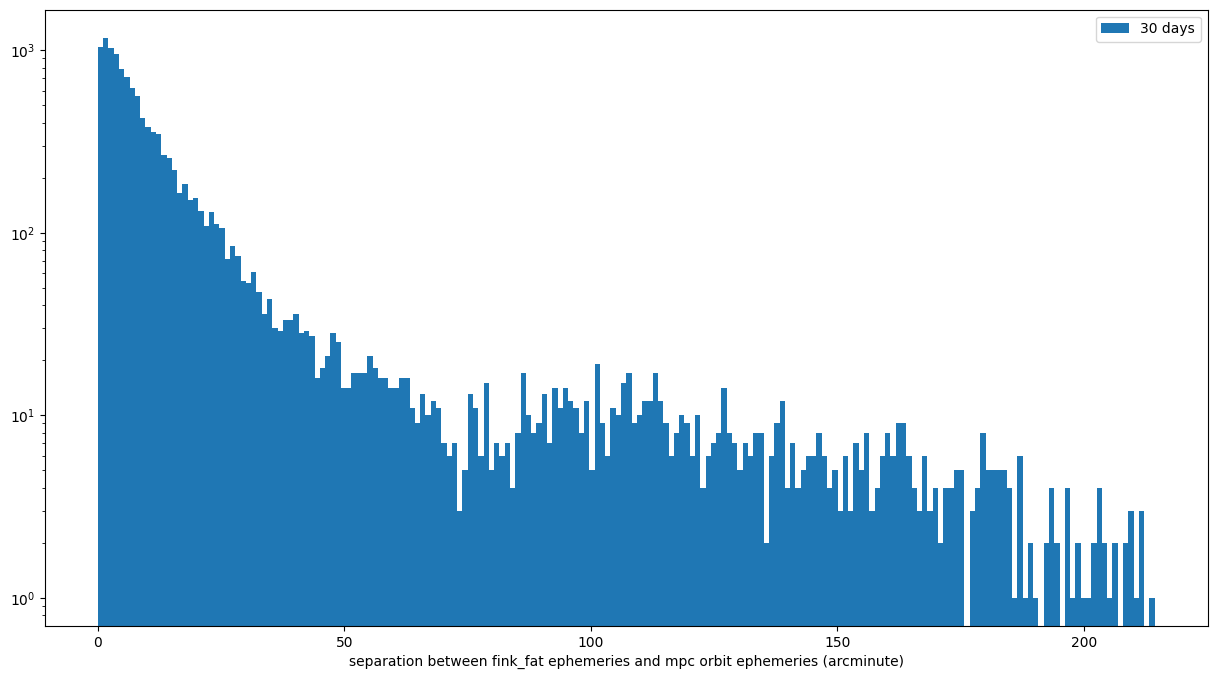

In [38]:
fig = plt.figure(figsize=(15, 8))

plt.hist(sep_30[sep_30 < np.percentile(sep_30, 99)].arcminute, bins=200, label="30 days")

plt.yscale("log")
plt.xlabel("separation between fink_fat ephemeries and mpc orbit ephemeries (arcminute)")
plt.legend()
plt.show()

In [101]:
print("median 120 day: {:.4f} arcminute".format(np.median(sep_120["sep"])))

median 120 day: 38.6128 arcminute


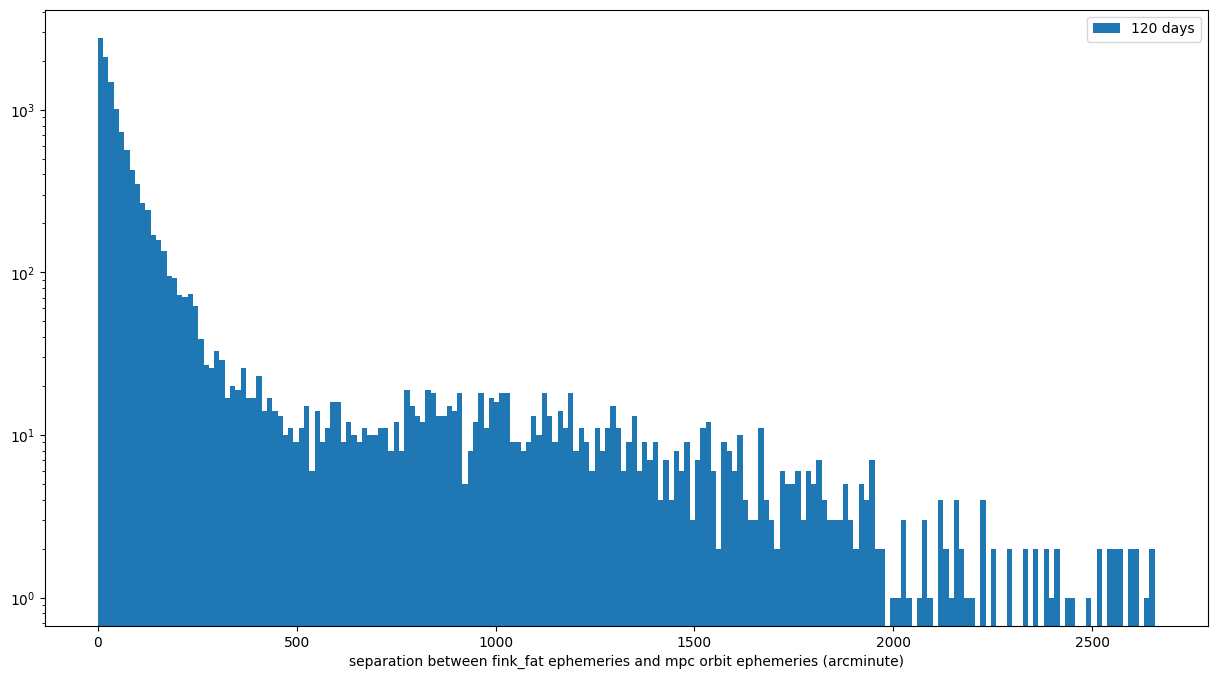

In [39]:
fig = plt.figure(figsize=(15, 8))

plt.hist(sep_120[sep_120 < np.percentile(sep_120, 99)].arcminute, bins=200, label="120 days")

plt.yscale("log")
plt.xlabel("separation between fink_fat ephemeries and mpc orbit ephemeries (arcminute)")
plt.legend()
plt.show()

In [103]:
print("median 360 day: {:.4f} arcminute ({:.4f} degree)".format(np.median(sep_360["sep"]), np.median(sep_360["sep"]) / 60))

median 360 day: 577.8260 arcminute (9.6304 degree)


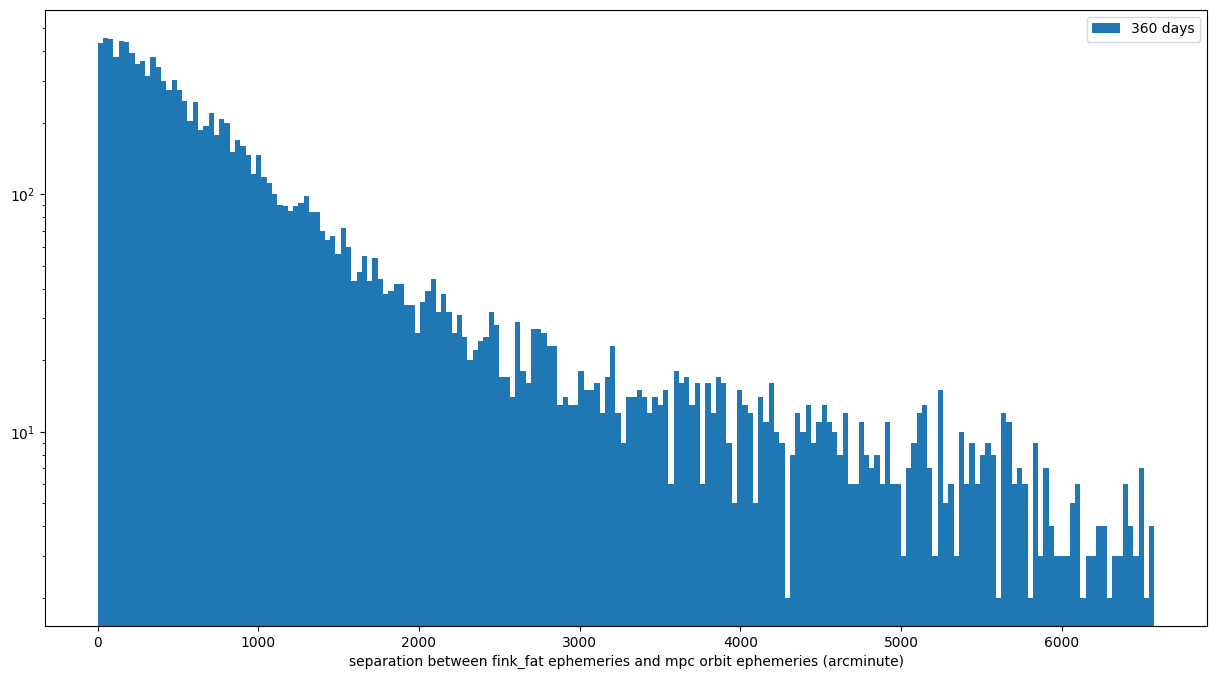

In [40]:
fig = plt.figure(figsize=(15, 8))

plt.hist(sep_360[sep_360 < np.percentile(sep_360, 99)].arcminute, bins=200, label="360 days")

plt.yscale("log")
plt.xlabel("separation between fink_fat ephemeries and mpc orbit ephemeries (arcminute)")
plt.legend()
plt.show()

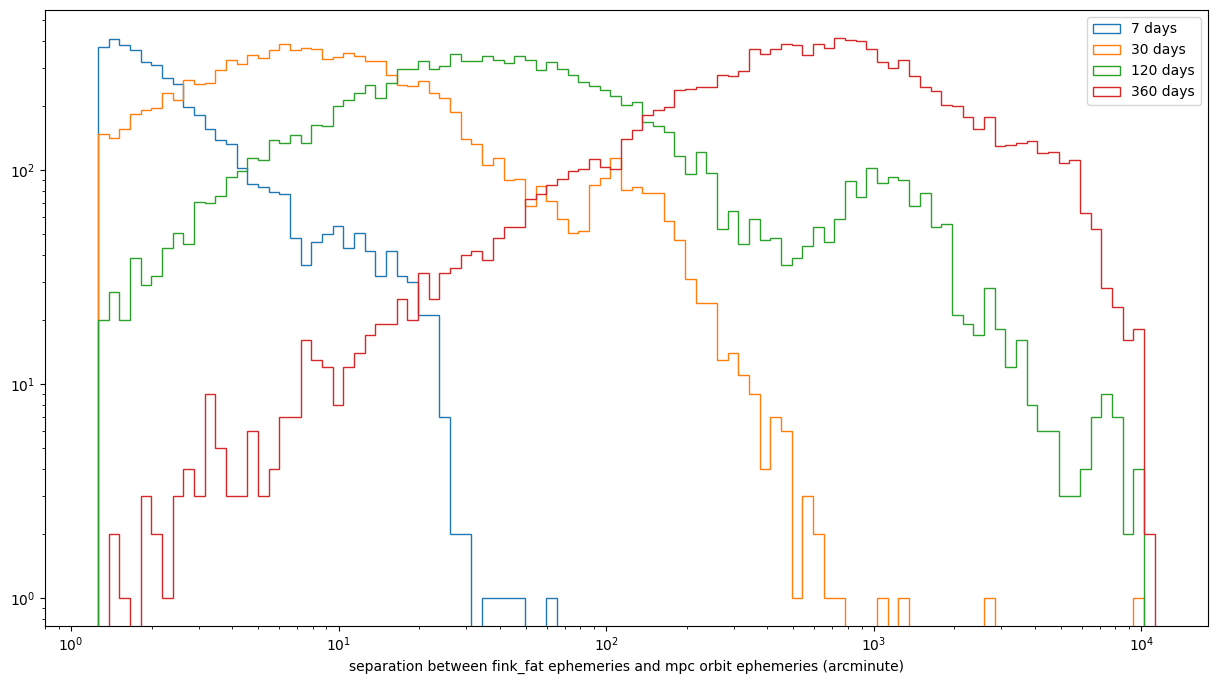

In [105]:
fig = plt.figure(figsize=(15, 8))

bins = np.logspace(0.1, 4.05, 100)

plt.hist(sep_7["sep"], bins=bins, label="7 days", histtype='step')
plt.hist(sep_30["sep"], bins=bins, label="30 days", histtype='step')
plt.hist(sep_120["sep"], bins=bins, label="120 days", histtype='step')
plt.hist(sep_360["sep"], bins=bins, label="360 days", histtype='step')

plt.yscale("log")
plt.xscale("log")
plt.xlabel("separation between fink_fat ephemeries and mpc orbit ephemeries (arcminute)")
plt.legend()
plt.show()